# Solution with neural network

## Data preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('../Data/new_dataset.csv', index_col=0)
df

,x,y,map1,map2,map3,map4,map5,F
0,44222.21,35600.90,0.176186,0.126131,41.556516,4041.398236,1.680261,14.974396
1,60003.40,26172.72,0.149917,0.118628,36.254009,4198.222325,1.680001,14.078868
2,44300.61,35291.79,0.171378,0.131456,41.683122,4073.275742,1.680756,14.261570
3,52776.47,33453.18,0.138782,0.132158,37.245744,4294.829957,1.682911,15.347562
4,49636.39,30697.34,0.143071,0.118760,37.347923,4196.356138,1.678776,14.422570
...,...,...,...,...,...,...,...,...
436,65193.40,26832.74,0.156005,0.121542,35.596017,4269.430884,1.671101,9.374795
437,50022.04,40606.42,0.163861,0.137037,41.562755,4172.894372,1.670731,7.636603
438,43745.18,35114.25,0.177447,0.120267,41.853524,4032.878957,1.678893,14.622497
439,71483.43,25152.76,0.149991,0.118253,41.093785,4178.472915,1.678914,11.014532


In [3]:
from sklearn.model_selection import train_test_split

In [4]:
cols = df.columns.tolist()
cols.remove('F')
X_train, X_test, y_train, y_test = train_test_split(df[cols], df['F'], test_size=0.2, shuffle=True)

len(X_train), len(X_test)

(352, 89)

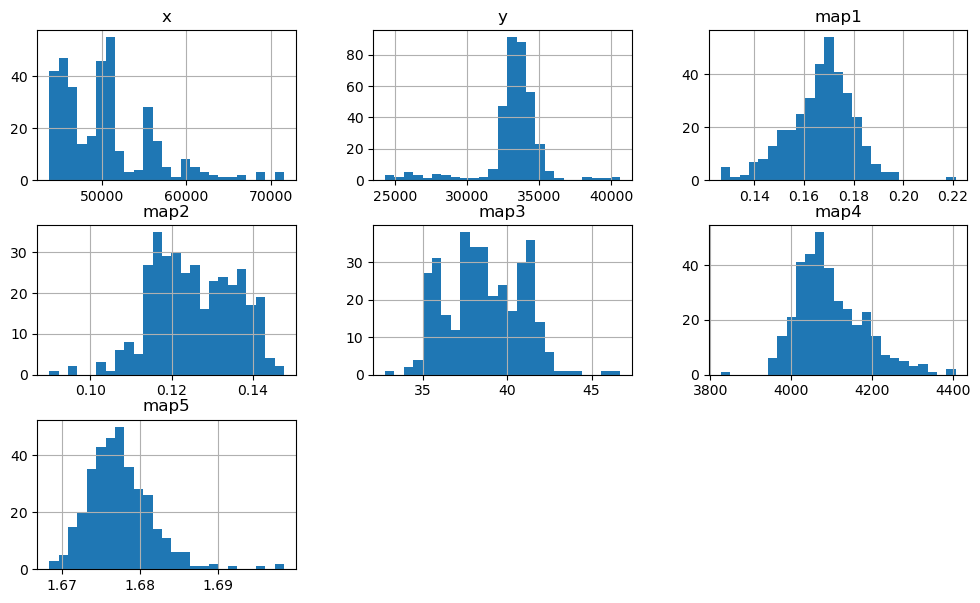

In [5]:
X_train.hist(figsize=(12, 7), bins=25)
None

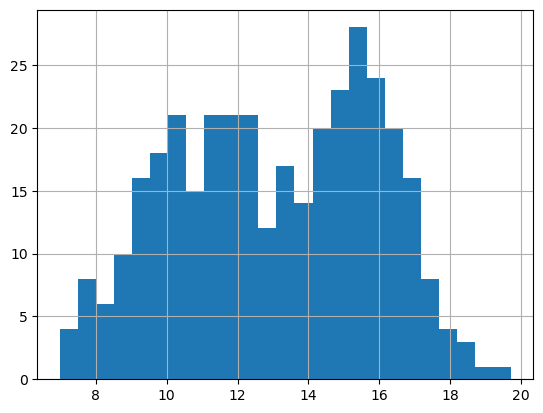

In [6]:
y_train.hist(bins=25)
None

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_train = scaler.fit_transform(X_train.values.astype(np.float32))
scaled_test = scaler.transform(X_test.values.astype(np.float32))

scaler.mean_, scaler.var_

(array([5.04106382e+04, 3.32160179e+04, 1.66660182e-01, 1.25645140e-01,
        3.86229662e+01, 4.09674528e+03, 1.67740785e+00]),
 array([2.96695866e+07, 4.26211386e+06, 1.71126105e-04, 1.02451160e-04,
        5.13548742e+00, 7.02004102e+03, 1.71045934e-05]))

## Datasets & Dataloaders

In [8]:
from torch.utils.data import Dataset, DataLoader
import torch

In [9]:
class RosneftDataset(Dataset):

    def __init__(self, X, y) -> None:
        self.X = X
        self.y = y

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]), torch.tensor(self.y[idx]).unsqueeze(0)

    def __len__(self):
        return len(self.y)

In [10]:
train_dataset = RosneftDataset(scaled_train, y_train.values.astype(np.float32))
test_dataset = RosneftDataset(scaled_test, y_test.values.astype(np.float32))

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=True)

## Model architecture

In [11]:
import torch.nn as nn

In [12]:
class RosneftMLP(nn.Module):

    def __init__(self, hidden_size=10) -> None:
        super().__init__()

        self.hidden_size = hidden_size

        self.linear = nn.Sequential(
            nn.Linear(in_features=7, out_features=hidden_size),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size, out_features=1),
        )

    def forward(self, x):
        # input x: [BATCH_SIZE x 7]
        return self.linear(x)

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [14]:
losses = None


def train(model, criterion, optimizer, epoches, tr_loader, val_loader):
    global losses
    losses = {
        'train': [],
        'val': [],
    }
    
    for epoch in range(epoches):

        # train
        model.train()
        train_loss = 0

        for X_batch, y_batch in tr_loader:
            X_batch_cuda = X_batch.to(device)

            optimizer.zero_grad()
            y_pred = model(X_batch_cuda)
            loss = criterion(y_batch.to(device), y_pred)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()**0.5
        
        losses['train'].append(train_loss / len(tr_loader))
        
        # val
        model.eval()
        val_loss = 0

        for X_batch, y_batch in val_loader:
            X_batch_cuda = X_batch.to(device)

            with torch.no_grad():
                y_pred = model(X_batch_cuda)
                loss = criterion(y_batch.to(device), y_pred)

            val_loss += loss.item()**0.5
        
        losses['val'].append(val_loss / len(val_loader))

        # show epoch results
        print(f'Epoch: {epoch+1}/{epoches}; Train loss: {losses["train"][-1]}; Val loss: {losses["val"][-1]}')

In [15]:
model = RosneftMLP().to(device)

epoches = 72
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [16]:
train(model, criterion, optimizer, epoches, train_dataloader, test_dataloader)

Epoch: 1/72; Train loss: 13.164975885071993; Val loss: 13.560774355261268
Epoch: 2/72; Train loss: 12.95177281929287; Val loss: 12.781034196810372
Epoch: 3/72; Train loss: 12.727287537741786; Val loss: 12.726808083449148
Epoch: 4/72; Train loss: 12.473951226663639; Val loss: 12.480918459251257
Epoch: 5/72; Train loss: 12.163125630231082; Val loss: 12.208877064362277
Epoch: 6/72; Train loss: 11.784492677428524; Val loss: 11.919697255524909
Epoch: 7/72; Train loss: 11.330375654564735; Val loss: 11.328524743798042
Epoch: 8/72; Train loss: 10.800448907117714; Val loss: 10.51991077694086
Epoch: 9/72; Train loss: 10.199640587968151; Val loss: 9.703353914743165
Epoch: 10/72; Train loss: 9.536617278208675; Val loss: 9.118039573752592
Epoch: 11/72; Train loss: 8.830373218784901; Val loss: 8.099097625954712
Epoch: 12/72; Train loss: 8.11120044089143; Val loss: 7.528191614795858
Epoch: 13/72; Train loss: 7.418966820700984; Val loss: 6.883662550039457
Epoch: 14/72; Train loss: 6.751421744358803; V

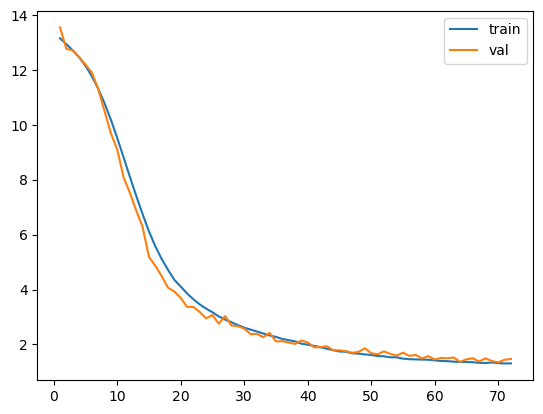

In [17]:
sk = 0 # skip
epoches_range = list(range(sk + 1, len(losses['train']) + 1))

plt.plot(epoches_range, losses['train'][sk:], label='train')
plt.plot(epoches_range, losses['val'][sk:], label='val')
plt.legend()

## Estimation

In [18]:
from sklearn.metrics import mean_squared_error


pred = model(torch.tensor(scaled_test).to(device)).cpu().detach().numpy()
mse = mean_squared_error(y_test, pred)
mse**0.5

1.5425590414893564

## Tests

In [19]:
X_batch, y_batch = next(iter(test_dataloader))
model.eval()

with torch.no_grad():
    y_pred = model(X_batch.to(device))


print('ground truth:')
print(y_batch)
print('prediction:')
print(y_pred)

ground truth:
tensor([[10.7850],
        [ 9.1871],
        [13.8736],
        [17.6170],
        [10.2801],
        [13.8323],
        [15.4833],
        [16.3032]])
prediction:
tensor([[10.2283],
        [ 8.8783],
        [11.1583],
        [17.0917],
        [10.0294],
        [14.0606],
        [15.0093],
        [16.1854]])


## Saving

In [20]:
torch.save(model.state_dict(), 'nn_weights.saved')